# Part 1: Exploratory Data Analysis

In [1]:
import pandas as pd
import json
import numpy as np
from datetime import datetime, time, timedelta
import matplotlib.pyplot as plt

import functions as fn

In [2]:
# Read in the data and sort the values
df = pd.read_json('logins.json').sort_values('login_time').reset_index().drop('index', axis=1)

In [3]:
# Divide into 15 minute time intervals and count the number of logins in each interval
count_list = []
t_start = df.login_time[0]
t_stop = t_start + timedelta(minutes=15)
count=0

for t in df.login_time:
    if t < t_stop:
        count+=1
    else:
        count_list.append(count)
        count=0
        t_stop+=timedelta(minutes=15)
        count+=1

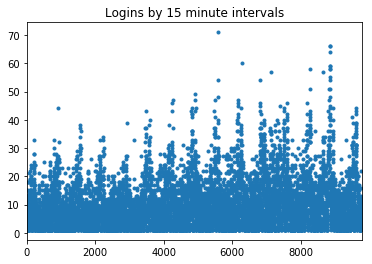

In [4]:
# Plot the login times as a time series
pd.Series(count_list).plot(style='.')
plt.title('Logins by 15 minute intervals')
plt.savefig('Logins_by_intervals.png')
plt.show()

In [5]:
# Add a column to the dataframe containing the day of the month
day_list = [df.login_time[i].day for i in df.index]
df['day'] = day_list

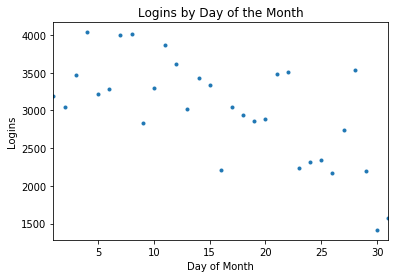

In [6]:
# Visualize the number of logins by day of the month
day_count = df.groupby(by='day').count().rename(columns={'login_time': 'login_count'})
counts = day_count.login_count

counts.plot(style='.')
plt.title('Logins by Day of the Month')
plt.xlabel('Day of Month')
plt.ylabel('Logins')
plt.savefig('Logins_by_day.png')
plt.show()

### In the plot above we can see that there is a downward trend in the month. In general, there are more logins at the beginning of the month than at the end of the month

In [7]:
# Add a column to the dataframe containing the hour of the day
hour_list = [df.login_time[i].hour for i in df.index]
df['hour'] = hour_list

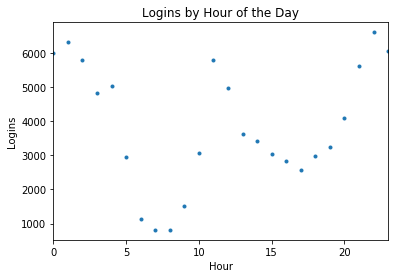

In [8]:
# Visualize the number of logins by hour of the day
hour_count = df.groupby(by='hour').count().rename(columns={'login_time': 'login_count_by_hr'}).drop('day', axis=1)
counts = hour_count.login_count_by_hr

counts.plot(style='.')
plt.title('Logins by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Logins')
plt.savefig('Logins_by_hour.png')
plt.show()

### We can see that the number of logins is highest around midnight and around noon. It is lowest between about 5:00 am and 10:00 am.

In [9]:
day1 = df[df.login_time < '1970-01-02']

day_list = []
t_start = day1.login_time[0]
t_stop = t_start + timedelta(minutes=15)
count=0

for t in day1.login_time:
    if t < t_stop:
        count+=1
    else:
        day_list.append(count)
        count=0
        t_stop+=timedelta(minutes=15)
        count+=1

# Part 3: Predictive Modeling

In [46]:
# Load the data into a dataframe
data = pd.DataFrame(json.load(open('ultimate_data_challenge.json')))

In [47]:
# Convert the last trip date to a datetime object
data['last_trip_date'] = pd.to_datetime(data.last_trip_date)
data['signup_date'] = pd.to_datetime(data.signup_date)

In [48]:
# Find the most recent trip and the date 30 days prior to this
most_recent_trip = data.sort_values('last_trip_date').tail(1).last_trip_date
dr = (most_recent_trip - timedelta(days=30)).iloc[0]

In [49]:
# Extract the data where the last trip date is within the last 30 days
retained = data[data.last_trip_date > dr]

In [50]:
print('The proportion of users retained is: {}'.format(retained.shape[0]/data.shape[0]))

The proportion of users retained is: 0.3662


### Build a model to predict whether a user will be active in their 6th month on the system

In [51]:
# Create a column indicating whether the user was active in their 6th month on the system
active = []
for i in data.index:
    if data.last_trip_date[i] >= dr:
        active.append(1)
    else:
        active.append(0)
        
data['active_month6'] = active

In [52]:
# Convert signup date to just the day (int value) so that it can be used in the model
data['signup_date'] = data.signup_date.dt.day

In [53]:
data = data.drop('last_trip_date', axis=1)

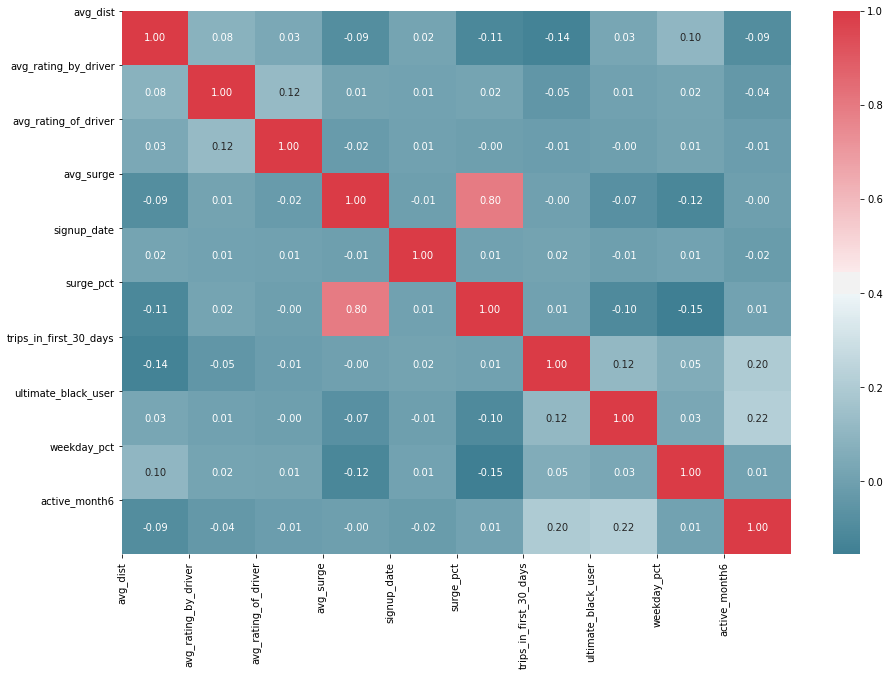

In [54]:
# Look at the correlation between features
fn.get_corr_heat_map(data, False)
plt.show()

In [55]:
import sklearn 
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [56]:
# Use PCA for dimension reduction
X1 = data[['avg_surge', 'surge_pct']]
pca = PCA()
pca.fit(X1)
print(np.round(pca.explained_variance_ratio_, decimals=4)*100)

[100.   0.]


### The first variable explains 100% of the variance, so the second variable is not needed in the model

In [57]:
transformed = pca.fit_transform(X1)
# Add the transformed features to the dataframe
data['PCA1'] = transformed[:,0]

In [58]:
# Encode the city values so that it can be used by the model
le = LabelEncoder()
data['city'] = le.fit_transform(data.city)

In [59]:
# Drop the columns that are not needed
data = data.drop(['phone', 'avg_surge', 'surge_pct'], axis=1)

In [60]:
X = data.drop('active_month6', axis=1)
y = data.active_month6
# split into test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': 15,
        'max_depth': 8,
        'learning_rate': 0.05,
        'min_data_in_leaf': 1000
                }

model = lgb.train(params, lgb_train, 100)

In [61]:
y_pred = model.predict(X_test)

In [62]:
# Convert the probabilities to binary values
for i in range(0, len(y_pred)-1):
    if y_pred[i]>=0.5:
        y_pred[i]=1
    else:
        y_pred[i]=0

y_pred = y_pred.astype(int)

In [63]:
# Compute the accuracy on the test data
print(accuracy_score(y_test, y_pred))

0.7714666666666666


### The model predicts rider retention with about 77% accuracy on the testing data

In [65]:
# Compute the accuracy on the training data. 
y_pred2 = model.predict(X_train)
# Convert the probabilities to binary values
for i in range(0, len(y_pred2)-1):
    if y_pred2[i]>=0.5:
        y_pred2[i]=1
    else:
        y_pred2[i]=0

y_pred2 = y_pred2.astype(int)
print(accuracy_score(y_train, y_pred2))

0.7792


### The accuracy on the test data is almost the same as on the training data, so the model is not overfitting